## Variable Selection for Classifier that Predicts Death of Heart Failure Patients


## Introduction

Heart failure occurs when the damaged or weakened heart muscle is unbale to pump blood efficiently to meet body’s needs. Multiple researches found that the risk factors of heart failure include but not limited to high blood pressure, diabetes, and smoking (Inamdar & Inamdar, 2016). This leads to the question of which predictor(s) are useful in predicting a heart failure patient’s survival after some period of time given their information. To answer this question, we will build models to analyze the “Heart Failure Prediction” dataset that was collected by Ahmad et al. in 2017. There are 11 predictors in the dataset but only 10 will be used:

* Age (years)
* Anaemia status (binary)
* Blood creatinine phosphokinase level (mcg/L) 
* Diabetes status (binary)
* Ejection fraction (percentage of blood leaving the heart at each contraction)
* High blood pressure status (binary)
* Platelets level in blood (kiloplatelets/mL)
* Level of serum creatinine in blood (mg/dL)
* Level of serum sodium in blood (mEq/L)
* Sex (binary, 0 for female and 1 for male)
* Smoking status (binary)

## Preliminary Exploratory Data Analysis

In [2]:
install.packages("themis")

also installing the dependencies ‘RANN’, ‘ROSE’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [67]:
# import libraries for R functions
library(repr)
library(tidyverse)
library(tidymodels)
library(dplyr)
options(repr.matrix.max.rows = 6)

In [4]:
library(themis)

In [5]:
# load data from the web
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00519/heart_failure_clinical_records_dataset.csv"
original_data <- read_csv(url)
# original_data

Rows: 299 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (13): age, anaemia, creatinine_phosphokinase, diabetes, ejection_fractio...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [6]:
# turn binary variables into factors

original_data <- original_data |>
    mutate(anaemia = as_factor(anaemia),
          diabetes = as_factor(diabetes),
          high_blood_pressure = as_factor(high_blood_pressure),
          platelets_num_per_mL = platelets/1000,
          sex = as_factor(sex),
          smoking = as_factor(smoking),
          DEATH_EVENT = as_factor(DEATH_EVENT))
original_data

# man is 1 in sex, woman is 0 since the paper said 194 men and 105 women, filtering for sex == 1 gives as 194 rows

age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT,platelets_num_per_mL
<dbl>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>
75,0,582,0,20,1,265000,1.9,130,1,0,4,1,265.000
55,0,7861,0,38,0,263358,1.1,136,1,0,6,1,263.358
65,0,146,0,20,0,162000,1.3,129,1,1,7,1,162.000
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
45,0,2060,1,60,0,742000,0.8,138,0,0,278,0,742
45,0,2413,0,38,0,140000,1.4,140,1,1,280,0,140
50,0,196,0,45,0,395000,1.6,136,1,1,285,0,395


In [7]:
# split the data into training and testing sets

set.seed(1625)

# split the data for 75% training and 25% testing, roughly same ratio of survived to dead in both sets as the original
data_split <- initial_split(original_data, prop = 0.75, strata = DEATH_EVENT)
training_data <- training(data_split)
testing_data <- testing(data_split)


In [8]:
# finding summary data of the training set

# mean of numerical predictors among survived or dead patients

numerical_preds <- c("Age (years)", "Creatinine phosphokinase (mcg/L)", "Ejection fraction (%)", "Platelet level (platelet/mL)", 
                     "Serum creatinine (mg/dL)", "Serum sodium (mEq/L)", "Follow-up period length (days)")

# make a function to find the mean of the numerical predictors among the survived patients
find_mean_survived <- function(dat) {
    
    result_list <- c()
    
    num_pred_only_data <- dat |> select(age, creatinine_phosphokinase, ejection_fraction, platelets_num_per_mL, 
                                        serum_creatinine, serum_sodium, time, DEATH_EVENT)
    
    for (i in 1:7) {
        
        curr_column <- num_pred_only_data[,i]
        death_event_column <- num_pred_only_data[,length(num_pred_only_data)]
        grouped_columns <- bind_cols(curr_column, death_event_column)
        as_tibble(grouped_columns)
        colnames(grouped_columns) <- c("Predictor", "Response")
        as_factor(grouped_columns$Response)
        
        result_list[i] <- mean(filter(grouped_columns, Response == 0)$Predictor, na.rm = TRUE)
        #mean_summary_dead[i] <- mean(filter(grouped_columns, Response == 1)$Predictor, na.rm = TRUE)
        
    }
    
    result_list
        
}


# make a function to find the mean of the numerical predictors among the dead patients
find_mean_dead <- function(dat) {
    
    result_list <- c()
    
    num_pred_only_data <- dat |> select(age, creatinine_phosphokinase, ejection_fraction, platelets_num_per_mL, 
                                        serum_creatinine, serum_sodium, time, DEATH_EVENT)
    
    for (i in 1:7) {
        
        curr_column <- num_pred_only_data[,i]
        death_event_column <- num_pred_only_data[,length(num_pred_only_data)]
        grouped_columns <- bind_cols(curr_column, death_event_column)
        as_tibble(grouped_columns)
        colnames(grouped_columns) <- c("Predictor", "Response")
        as_factor(grouped_columns$Response)
        
        result_list[i] <- mean(filter(grouped_columns, Response == 1)$Predictor, na.rm = TRUE)
        
    }
    
    result_list
        
}

# find the mean for each numerical predictors among the survived patients
mean_summary_survived <- find_mean_survived(training_data)

# find the mean for each numerical predictors among the dead patients
mean_summary_dead <- find_mean_dead(training_data)



# make a function to find the percentage of survived patients for each category of categorial variables

categorical_preds <- c("Anaemia", "No anameia", "Diabetes", "No diabetes", "High blood pressure", 
                       "No high blood pressure", "Male", "Female", "Smoker", "Non-smoker")


find_ratio_yes <- function(dat) {
    
    result_list <- c()
    
    categ_pred_only_data <- dat |> 
        select(anaemia, diabetes, high_blood_pressure, sex, smoking, DEATH_EVENT)
    
    for (i in 1:5) {
        
        curr_column <- categ_pred_only_data[,i]
        death_event_column <- categ_pred_only_data[,length(categ_pred_only_data)]
        grouped_columns <- bind_cols(curr_column, death_event_column)
        as_tibble(grouped_columns)
        
        colnames(grouped_columns) <- c("Predictor", "Response")
        
        as_factor(grouped_columns$Predictor)
        as_factor(grouped_columns$Response)
        
        
        filtered_response_yes <- filter(grouped_columns, Predictor == 1)[,2]

        number_survived_yes <- nrow(filter(filtered_response_yes, Response == 0))
        
        result_list[i] <- number_survived_yes/nrow(filtered_response_yes)*100
        
    }
    
    result_list
        
}



find_ratio_no <- function(dat) {
    
    result_list <- c()
    
    categ_pred_only_data <- dat |> 
        select(anaemia, diabetes, high_blood_pressure, sex, smoking, DEATH_EVENT)
    
    for (i in 1:5) {
        
        curr_column <- categ_pred_only_data[,i]
        death_event_column <- categ_pred_only_data[,length(categ_pred_only_data)]
        grouped_columns <- bind_cols(curr_column, death_event_column)
        as_tibble(grouped_columns)
        
        colnames(grouped_columns) <- c("Predictor", "Response")
        
        as_factor(grouped_columns$Predictor)
        as_factor(grouped_columns$Response)
        
        
        filtered_response_no <- filter(grouped_columns, Predictor == 0)[,2]

        number_survived_no <- nrow(filter(filtered_response_no, Response == 0))
        
        result_list[i] <- number_survived_no/nrow(filtered_response_no)*100
        
    }
    
    result_list
        
}

ratio_summary_yes <- find_ratio_yes(training_data)

ratio_summary_no <- find_ratio_no(training_data)

ratio_summary <- c(ratio_summary_yes[1], ratio_summary_no[1],
                   ratio_summary_yes[2], ratio_summary_no[2],
                   ratio_summary_yes[3], ratio_summary_no[3],
                   ratio_summary_yes[4], ratio_summary_no[4],
                   ratio_summary_yes[5], ratio_summary_no[5])


##### Summary Table 1. Mean of numerical predictors across survived and dead patients

In [9]:
# Create summary table 1
options(repr.matrix.max.rows = 10)
table_1 <- tibble(numerical_preds, round(mean_summary_survived, 4), round(mean_summary_dead, 4))
colnames(table_1) <- c("Predictor", "Mean predictor value among survived patients", "Mean predictor value among dead patients")
head(table_1, n = 10)

Predictor,Mean predictor value among survived patients,Mean predictor value among dead patients
<chr>,<dbl>,<dbl>
Age (years),59.2675,65.5232
Creatinine phosphokinase (mcg/L),521.2368,612.4583
Ejection fraction (%),40.4408,33.5694
Platelet level (platelet/mL),267.9566,255.1737
Serum creatinine (mg/dL),1.2170,1.8928
Serum sodium (mEq/L),136.8684,135.1389
Follow-up period length (days),164.6447,74.0139


In [10]:
# Create summary table 2
options(repr.matrix.max.rows = 10)
table_2 <- tibble(categorical_preds, round(ratio_summary, 4))
colnames(table_2) <- c("Predictor", "Percentage of survived patients")
head(table_2, 10)

Predictor,Percentage of survived patients
<chr>,<dbl>
Anaemia,62.3656
No anameia,71.7557
Diabetes,68.4783
No diabetes,67.4242
High blood pressure,61.3333
No high blood pressure,71.1409
Male,69.9301
Female,64.1975
Smoker,70.8333


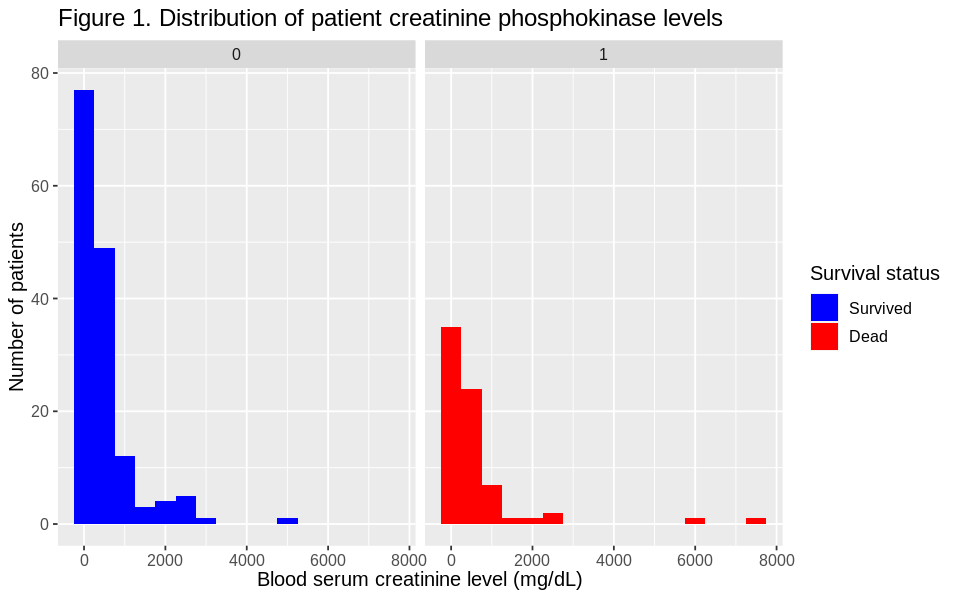

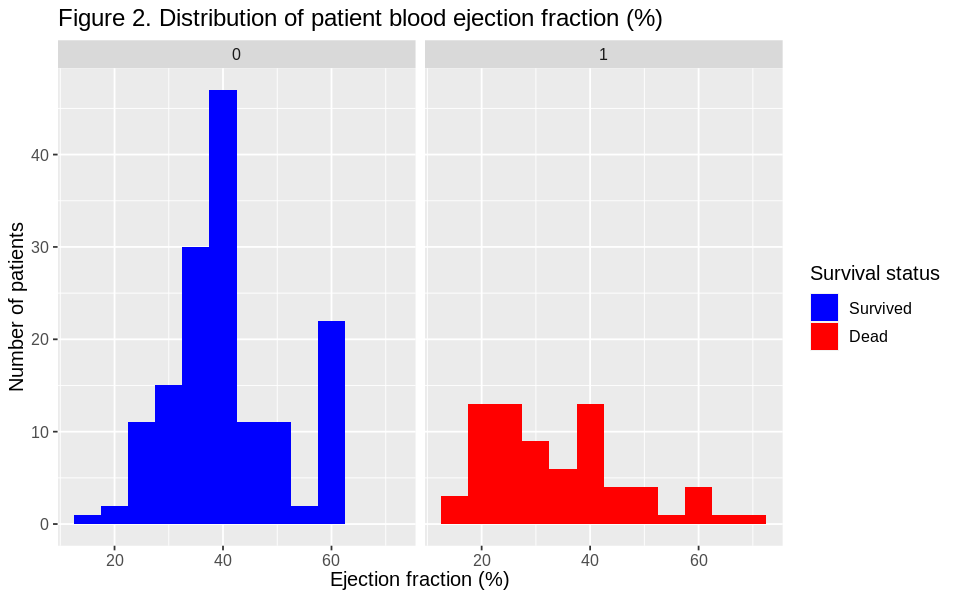

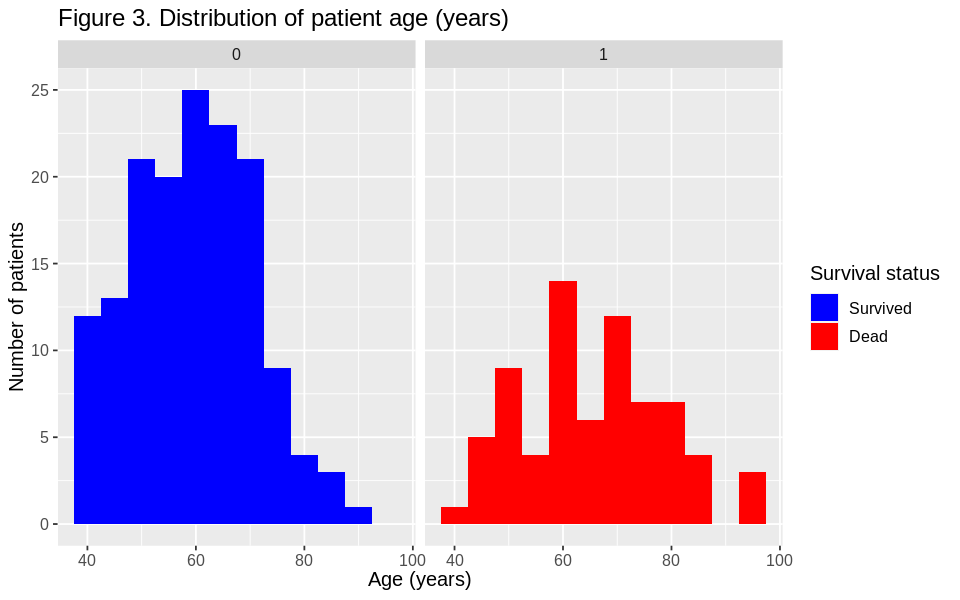

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



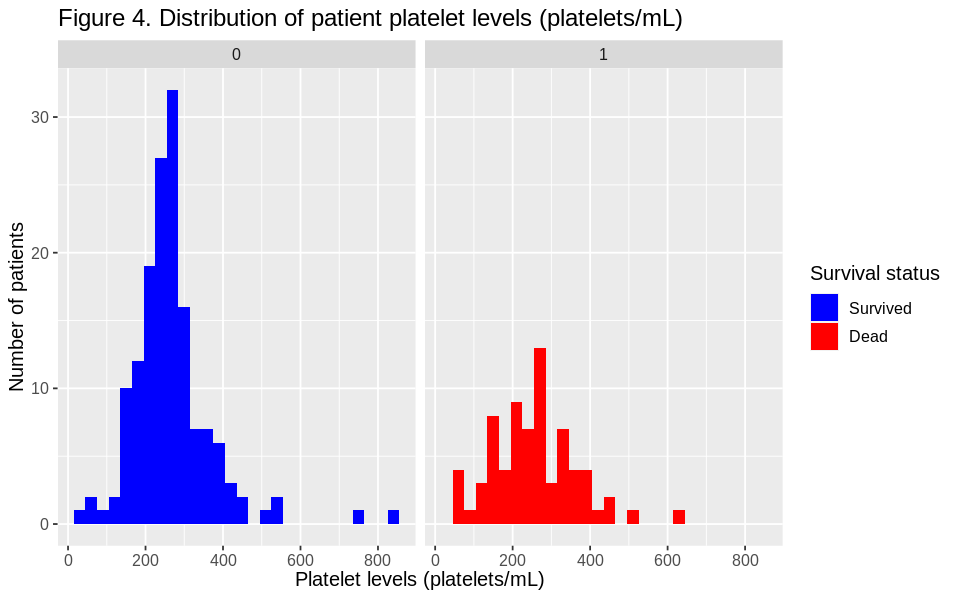

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



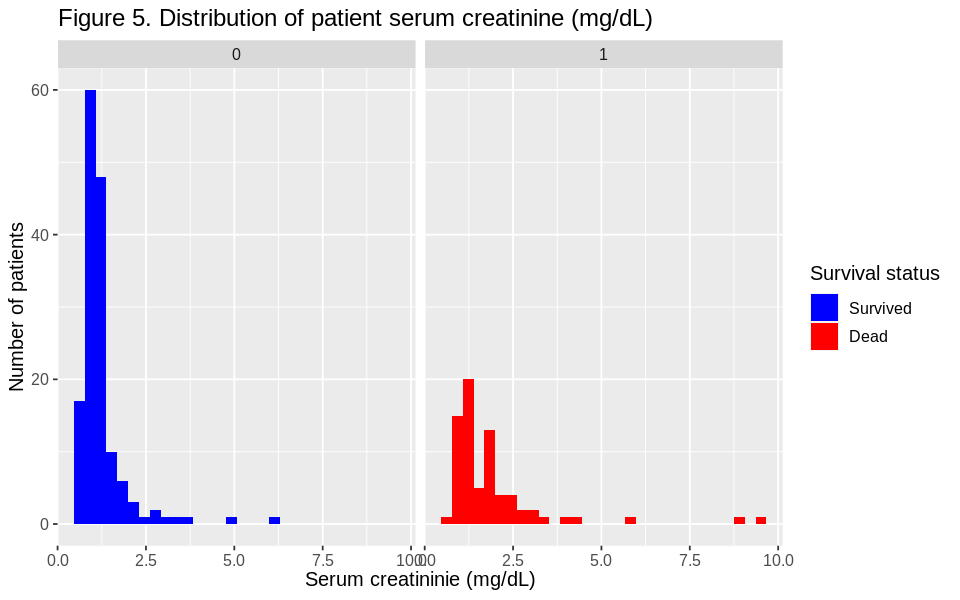

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



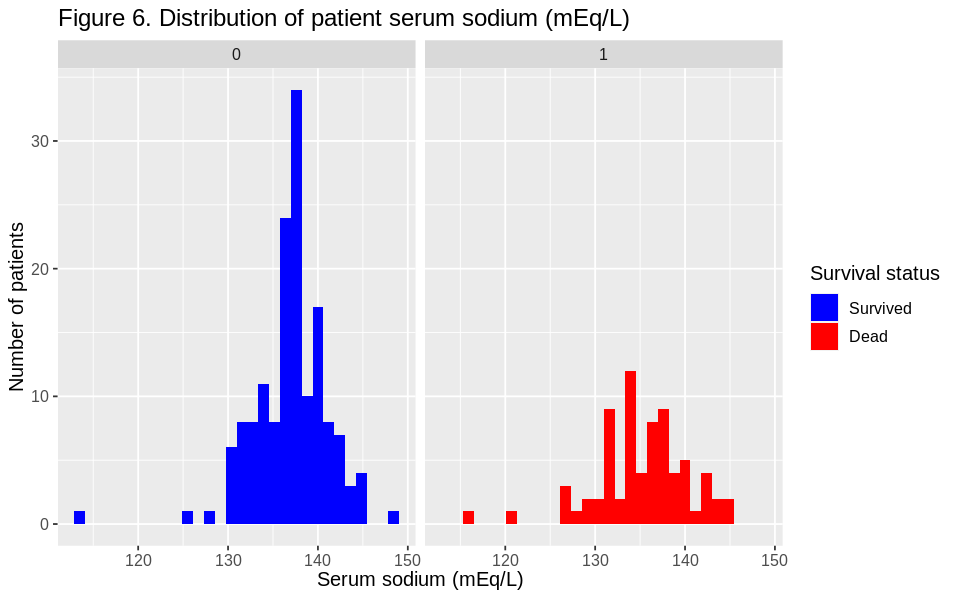

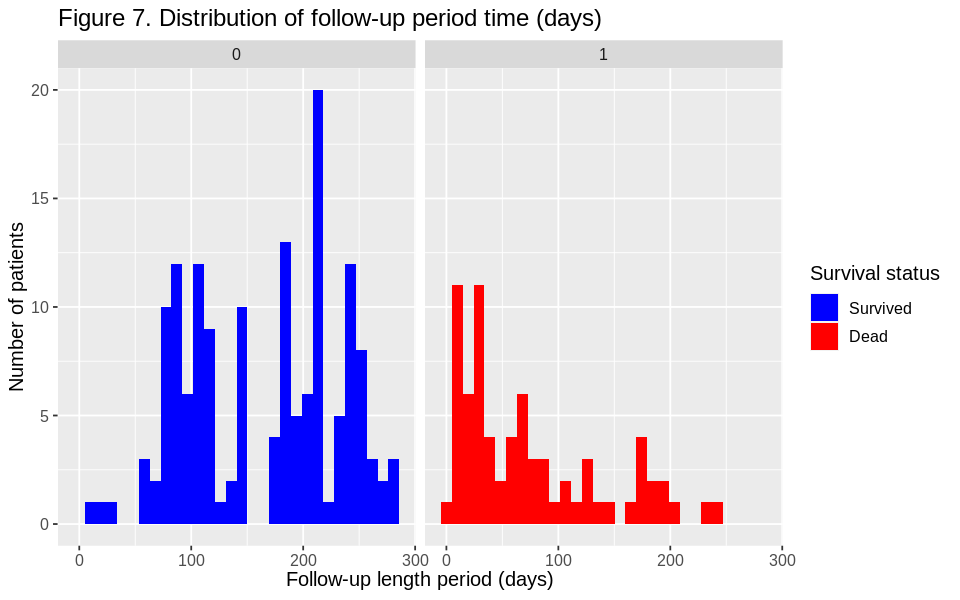

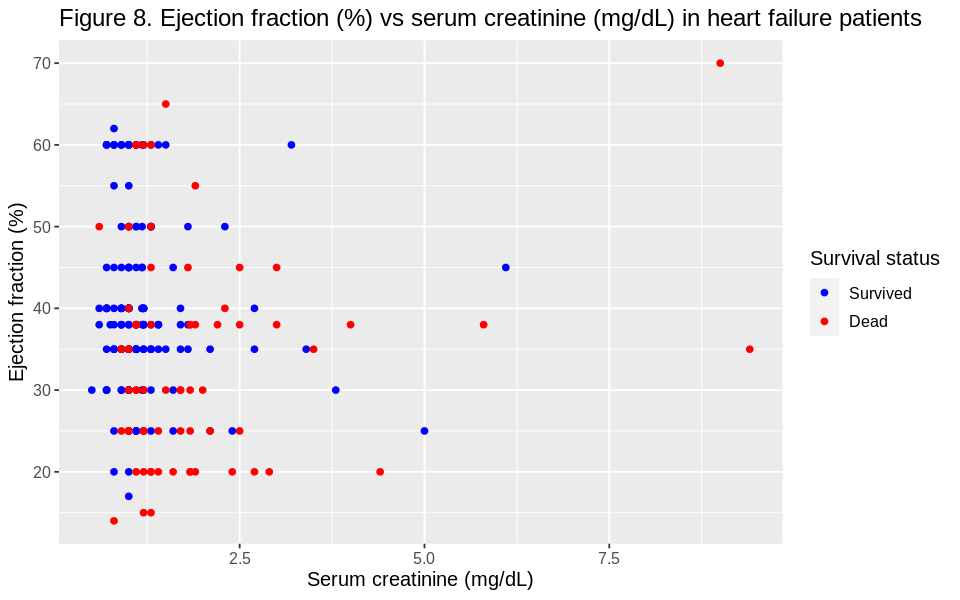

In [11]:
# Plots
options(repr.plot.height = 5, repr.plot.width = 8)

plot1 <- training_data |>
    ggplot(aes(x = creatinine_phosphokinase, fill = DEATH_EVENT)) +
    geom_histogram(binwidth = 500) +
    facet_grid(~DEATH_EVENT) +
    labs(x = "Blood serum creatinine level (mg/dL)",
         y = "Number of patients",
         fill = "Survival status",
         title = "Figure 1. Distribution of patient creatinine phosphokinase levels") + 
    scale_fill_manual(labels = c("Survived", "Dead"), values = c("blue", "red")) +
    theme(text = element_text(size = 12))

plot1

plot2 <- training_data |>
    ggplot(aes(x = ejection_fraction, fill = DEATH_EVENT)) +
    geom_histogram(binwidth = 5) +
    facet_grid(~DEATH_EVENT) +
    labs(x = "Ejection fraction (%)",
         y = "Number of patients",
         fill = "Survival status",
         title = "Figure 2. Distribution of patient blood ejection fraction (%)") +
    scale_fill_manual(labels = c("Survived", "Dead"), values = c("blue", "red")) +
    theme(text = element_text(size = 12))

plot2

plot3 <- training_data |>
    ggplot(aes(x = age, fill = DEATH_EVENT)) +
    geom_histogram(binwidth = 5) +
    facet_grid(~DEATH_EVENT) +
    labs(x = "Age (years)",
         y = "Number of patients",
         fill = "Survival status",
         title = "Figure 3. Distribution of patient age (years)") +
    scale_fill_manual(labels = c("Survived", "Dead"), values = c("blue", "red")) +
    theme(text = element_text(size = 12))

plot3

plot4 <- training_data |>
    ggplot(aes(x = platelets_num_per_mL, fill = DEATH_EVENT)) +
    geom_histogram(binwidth = 30) +
    facet_grid(~DEATH_EVENT) +
    labs(x = "Platelet levels (platelets/mL)",
         y = "Number of patients",
         fill = "Survival status",
         title = "Figure 4. Distribution of patient platelet levels (platelets/mL)") +
    scale_fill_manual(labels = c("Survived", "Dead"), values = c("blue", "red")) +
    theme(text = element_text(size = 12))

plot4

plot5 <- training_data |>
    ggplot(aes(x = serum_creatinine, fill = DEATH_EVENT)) +
    geom_histogram() +
    facet_grid(~DEATH_EVENT) +
    labs(x = "Serum creatininie (mg/dL)",
         y = "Number of patients",
         fill = "Survival status",
         title = "Figure 5. Distribution of patient serum creatinine (mg/dL)") +
    scale_fill_manual(labels = c("Survived", "Dead"), values = c("blue", "red")) +
    theme(text = element_text(size = 12))

plot5

plot6 <- training_data |>
    ggplot(aes(x = serum_sodium, fill = DEATH_EVENT)) +
    geom_histogram() +
    facet_grid(~DEATH_EVENT) +
    labs(x = "Serum sodium (mEq/L)",
         y = "Number of patients",
         fill = "Survival status",
         title = "Figure 6. Distribution of patient serum sodium (mEq/L)") +
    scale_fill_manual(labels = c("Survived", "Dead"), values = c("blue", "red")) +
    theme(text = element_text(size = 12))

plot6

plot7 <- training_data |>
    ggplot(aes(x = time, fill = DEATH_EVENT)) +
    geom_histogram() +
    facet_grid(~DEATH_EVENT) +
    labs(x = "Follow-up length period (days)",
         y = "Number of patients",
         fill = "Survival status",
         title = "Figure 7. Distribution of follow-up period time (days)") +
    scale_fill_manual(labels = c("Survived", "Dead"), values = c("blue", "red")) +
    theme(text = element_text(size = 12))

plot7

plot8 <- training_data |>
    ggplot(aes(x = serum_creatinine, y = ejection_fraction, color = DEATH_EVENT)) +
    geom_point() +
    labs(x = "Serum creatinine (mg/dL)",
         y = "Ejection fraction (%)",
         color = "Survival status",
         title = "Figure 8. Ejection fraction (%) vs serum creatinine (mg/dL) in heart failure patients") +
    scale_color_manual(labels = c("Survived", "Dead"), values = c("blue", "red")) +
    theme(text = element_text(size = 12))

plot8

### Predictor Variable Selection ###

#### GG Pair Plot ####

In [12]:
colnames(training_data)

[1] "age"                      "anaemia"                 
 [3] "creatinine_phosphokinase" "diabetes"                
 [5] "ejection_fraction"        "high_blood_pressure"     
 [7] "platelets"                "serum_creatinine"        
 [9] "serum_sodium"             "sex"                     
[11] "smoking"                  "time"                    
[13] "DEATH_EVENT"              "platelets_num_per_mL"

In [13]:
ups_recipe <- recipe(DEATH_EVENT ~ ., data = training_data) |>
  step_upsample(DEATH_EVENT, over_ratio = 1, skip = FALSE) |>
  prep()

ups_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor         13

Training data contained 224 data points and no missing data.

Operations:

Up-sampling based on DEATH_EVENT [trained]

In [14]:
balanced_data <- ups_recipe |> bake(training_data)
balanced_data

age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,platelets_num_per_mL,DEATH_EVENT
<dbl>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>
49,1,80,0,30,1,427000,1.0,138,0,0,12,427,0
53,0,63,1,60,0,368000,0.8,135,1,0,22,368,0
72,0,127,1,50,1,218000,1.0,134,1,0,33,218,0
70,1,75,0,35,0,223000,2.7,138,1,1,54,223,0
60,1,607,0,40,0,216000,0.6,138,1,1,54,216,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
75,0,99,0,38,1,224000,2.5,134,1,0,162,224,1
70,1,143,0,60,0,351000,1.3,137,0,0,90,351,1
45,1,981,0,30,0,136000,1.1,137,1,0,11,136,1


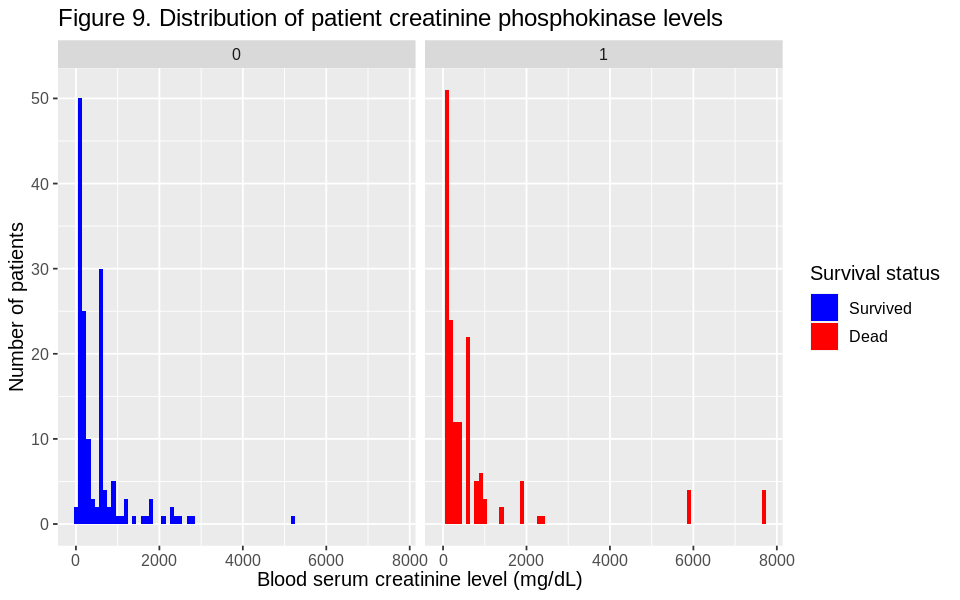

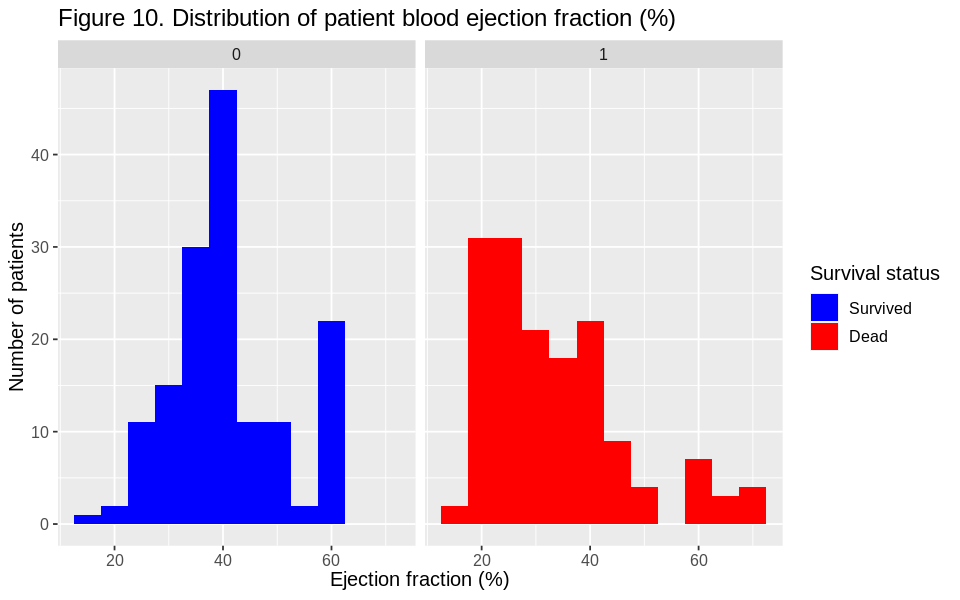

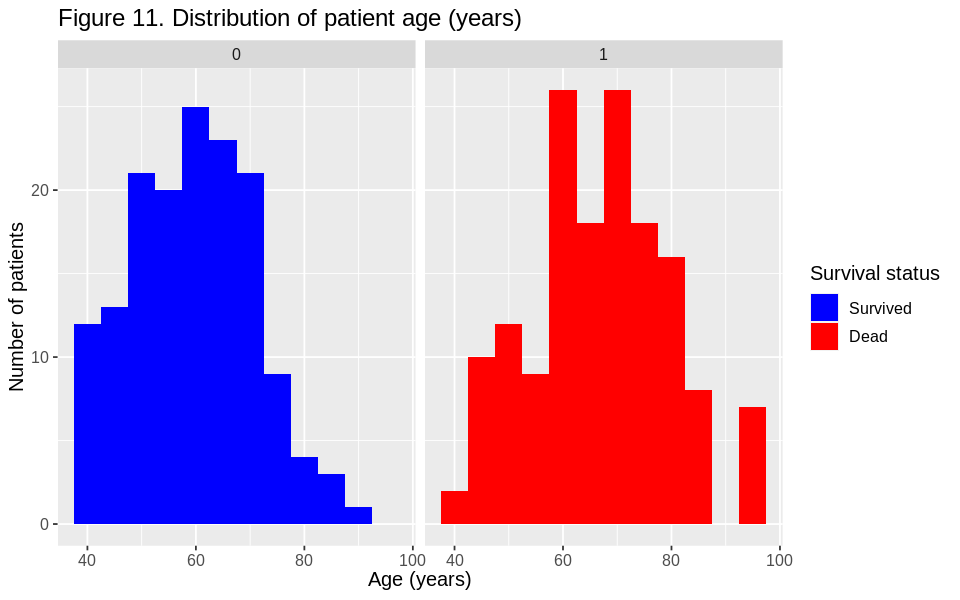

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



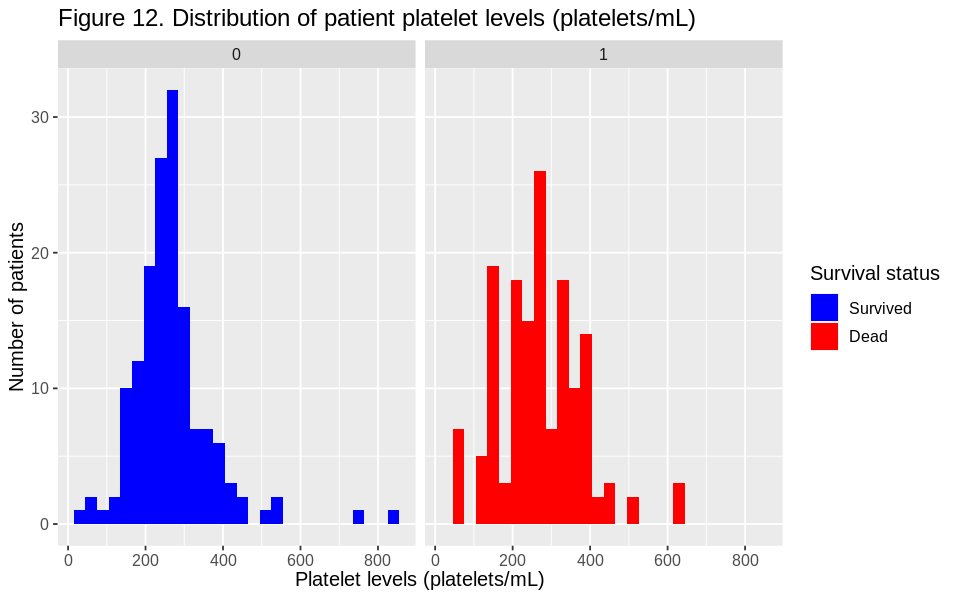

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



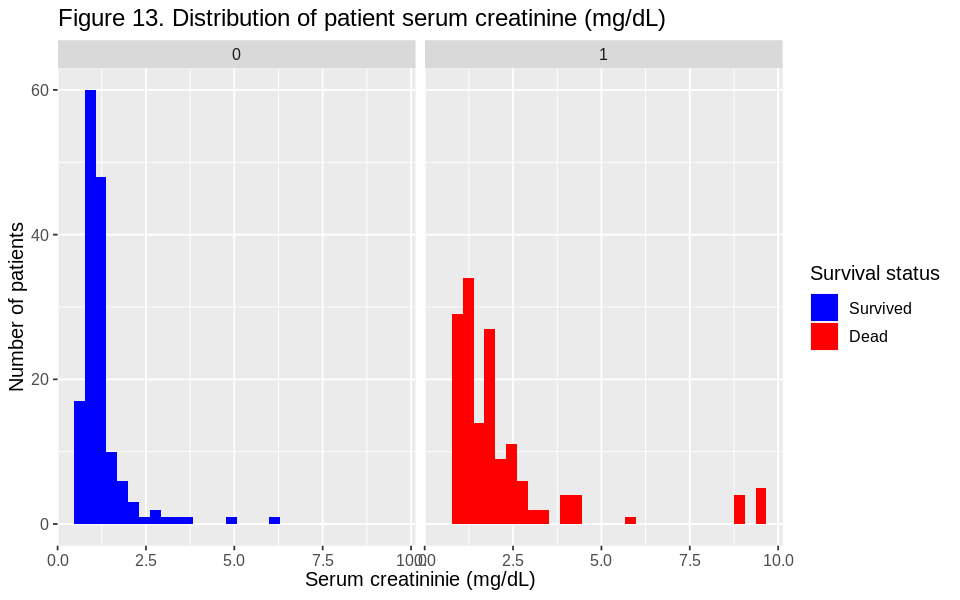

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



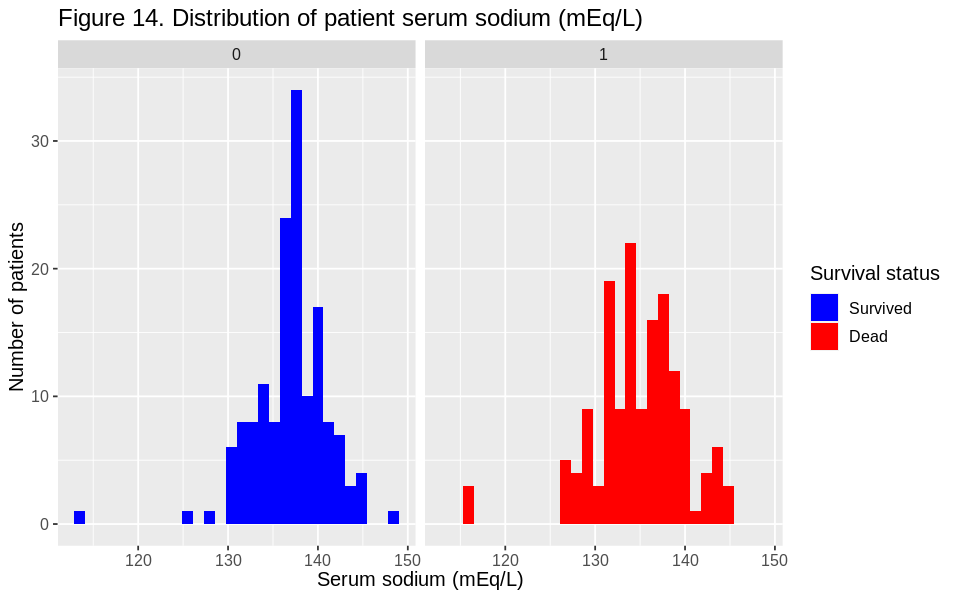

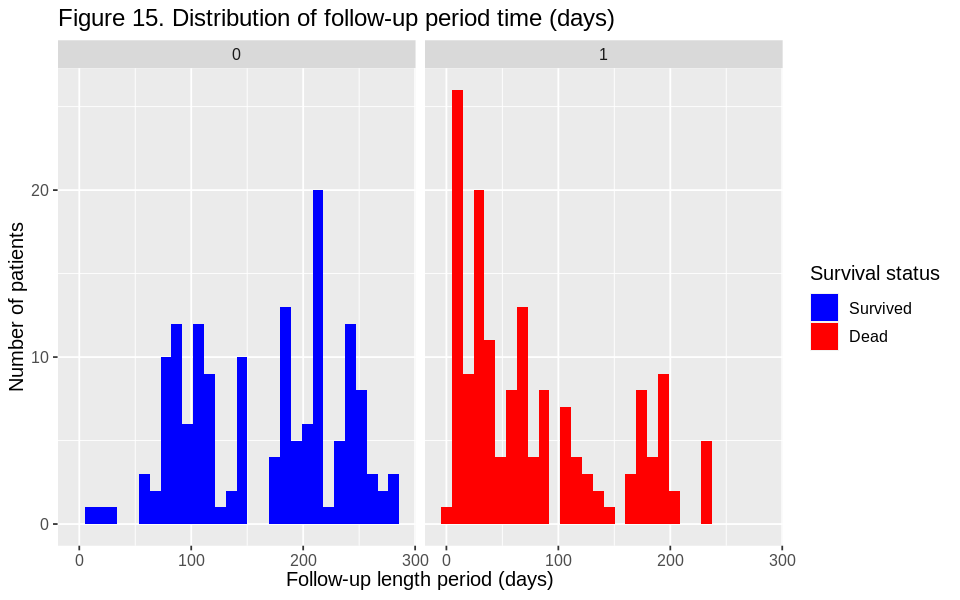

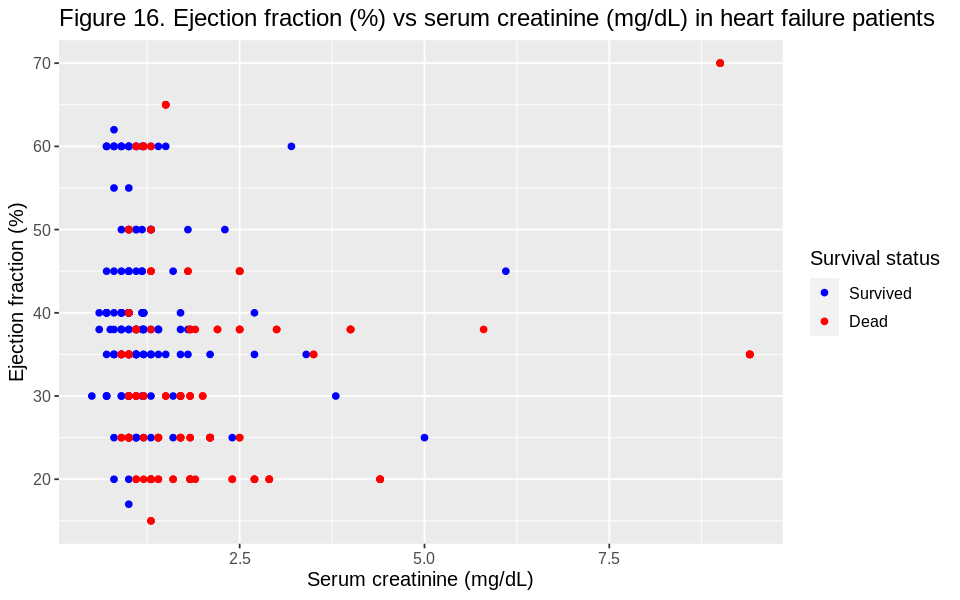

In [114]:
# Plots
options(repr.plot.height = 5, repr.plot.width = 8)

plot1 <- balanced_data |>
    ggplot(aes(x = creatinine_phosphokinase, fill = DEATH_EVENT)) +
    geom_histogram(binwidth = 100) +
    facet_grid(~DEATH_EVENT) +
    labs(x = "Blood serum creatinine level (mg/dL)",
         y = "Number of patients",
         fill = "Survival status",
         title = "Figure 9. Distribution of patient creatinine phosphokinase levels") + 
    scale_fill_manual(labels = c("Survived", "Dead"), values = c("blue", "red")) +
    theme(text = element_text(size = 12))

plot1

plot2 <- balanced_data |>
    ggplot(aes(x = ejection_fraction, fill = DEATH_EVENT)) +
    geom_histogram(binwidth = 5) +
    facet_grid(~DEATH_EVENT) +
    labs(x = "Ejection fraction (%)",
         y = "Number of patients",
         fill = "Survival status",
         title = "Figure 10. Distribution of patient blood ejection fraction (%)") +
    scale_fill_manual(labels = c("Survived", "Dead"), values = c("blue", "red")) +
    theme(text = element_text(size = 12))

plot2

plot3 <- balanced_data |>
    ggplot(aes(x = age, fill = DEATH_EVENT)) +
    geom_histogram(binwidth = 5) +
    facet_grid(~DEATH_EVENT) +
    labs(x = "Age (years)",
         y = "Number of patients",
         fill = "Survival status",
         title = "Figure 11. Distribution of patient age (years)") +
    scale_fill_manual(labels = c("Survived", "Dead"), values = c("blue", "red")) +
    theme(text = element_text(size = 12))

plot3

plot4 <- balanced_data |>
    ggplot(aes(x = platelets_num_per_mL, fill = DEATH_EVENT)) +
    geom_histogram(binwidth = 30) +
    facet_grid(~DEATH_EVENT) +
    labs(x = "Platelet levels (platelets/mL)",
         y = "Number of patients",
         fill = "Survival status",
         title = "Figure 12. Distribution of patient platelet levels (platelets/mL)") +
    scale_fill_manual(labels = c("Survived", "Dead"), values = c("blue", "red")) +
    theme(text = element_text(size = 12))

plot4

plot5 <- balanced_data |>
    ggplot(aes(x = serum_creatinine, fill = DEATH_EVENT)) +
    geom_histogram() +
    facet_grid(~DEATH_EVENT) +
    labs(x = "Serum creatininie (mg/dL)",
         y = "Number of patients",
         fill = "Survival status",
         title = "Figure 13. Distribution of patient serum creatinine (mg/dL)") +
    scale_fill_manual(labels = c("Survived", "Dead"), values = c("blue", "red")) +
    theme(text = element_text(size = 12))

plot5

plot6 <- balanced_data |>
    ggplot(aes(x = serum_sodium, fill = DEATH_EVENT)) +
    geom_histogram() +
    facet_grid(~DEATH_EVENT) +
    labs(x = "Serum sodium (mEq/L)",
         y = "Number of patients",
         fill = "Survival status",
         title = "Figure 14. Distribution of patient serum sodium (mEq/L)") +
    scale_fill_manual(labels = c("Survived", "Dead"), values = c("blue", "red")) +
    theme(text = element_text(size = 12))

plot6

plot7 <- balanced_data |>
    ggplot(aes(x = time, fill = DEATH_EVENT)) +
    geom_histogram() +
    facet_grid(~DEATH_EVENT) +
    labs(x = "Follow-up length period (days)",
         y = "Number of patients",
         fill = "Survival status",
         title = "Figure 15. Distribution of follow-up period time (days)") +
    scale_fill_manual(labels = c("Survived", "Dead"), values = c("blue", "red")) +
    theme(text = element_text(size = 12))

plot7

plot8 <- balanced_data |>
    ggplot(aes(x = serum_creatinine, y = ejection_fraction, color = DEATH_EVENT)) +
    geom_point() +
    labs(x = "Serum creatinine (mg/dL)",
         y = "Ejection fraction (%)",
         color = "Survival status",
         title = "Figure 16. Ejection fraction (%) vs serum creatinine (mg/dL) in heart failure patients") +
    scale_color_manual(labels = c("Survived", "Dead"), values = c("blue", "red")) +
    theme(text = element_text(size = 12))

plot8

#### Forward Variable Selection ####

In [15]:
nrow(balanced_data)

[1] 304

In [16]:
death <- balanced_data |>
filter(DEATH_EVENT == 1)
nrow(death)

[1] 152

In [17]:
# code is made based on references to Textbook section 6.8
# set seed for reproducible results
set.seed(2130)

# original order
wotime_train_ver_1 <- balanced_data |>
    select(age, anaemia, creatinine_phosphokinase, diabetes, ejection_fraction, high_blood_pressure, 
           platelets_num_per_mL, serum_creatinine, serum_sodium, sex, smoking, DEATH_EVENT)

# serum_creatinine and ejection_fraction first, other variables in a some-what random order
wotime_train_ver_2 <- balanced_data |>
    select(serum_creatinine, ejection_fraction, sex, age, creatinine_phosphokinase, anaemia, platelets_num_per_mL,
          smoking, diabetes, high_blood_pressure, serum_sodium, DEATH_EVENT)

# all numeric variables first, then binary variables
wotime_train_ver_3 <- balanced_data |>
    select(age, creatinine_phosphokinase, platelets_num_per_mL, ejection_fraction, serum_creatinine,
          serum_sodium, anaemia, diabetes, high_blood_pressure, sex, smoking, DEATH_EVENT)

# all binary variables first, then numeric variables
wotime_train_ver_4 <- balanced_data |>
    select(anaemia, diabetes, high_blood_pressure, sex, smoking, age, creatinine_phosphokinase, platelets_num_per_mL, 
           ejection_fraction, serum_creatinine, serum_sodium, DEATH_EVENT)

# random order
wotime_train_ver_5 <- balanced_data |>
    select(high_blood_pressure, serum_sodium, anaemia,diabetes, smoking, creatinine_phosphokinase, sex,
           platelets_num_per_mL, ejection_fraction, anaemia, serum_creatinine, age, DEATH_EVENT)


# turn this into a function
do_forward_selection <- function(data_train) {
    
    accuracies <- tibble(size = integer(),
                         model_formula = character(),
                         accuracy = numeric())

    knn_spec <- nearest_neighbor(weight_func = "rectangular",
                                 neighbors = tune()) |>
                    set_engine("kknn") |>
                    set_mode("classification")

    hf_vfold <- vfold_cv(data_train, v = 5, strata = DEATH_EVENT)

    names <- colnames(data_train |>
                      select(-DEATH_EVENT))

    example <- paste("DEATH_EVENT", "~", paste(names, collapse="+"))

    n_total <- length(names)

    selected <- c()

    for (i in 1:n_total) {
    
        accs <- list()
        models <- list()
    
        for (j in 1:length(names)) {
        
            preds_new <- c(selected, names[[j]])
            model_formula <- paste("DEATH_EVENT", "~", paste(preds_new, collapse = "+"))
    
            hf_recipe <- recipe(as.formula(model_formula),
                                data = data_train) |>
                         step_scale(all_numeric_predictors()) |> # only scale numeric variables
                         step_center(all_numeric_predictors())
        
            acc <- workflow() |>
                   add_recipe(hf_recipe) |>
                   add_model(knn_spec) |>
                   tune_grid(resamples = hf_vfold, grid = 10) |>
                   collect_metrics() |>
                   filter(.metric == "accuracy") |>
                   summarize(max_mean_accuracy = max(mean))
        
            acc <- acc$max_mean_accuracy |> unlist()
        
            accs[[j]] <- acc
            models[[j]] <- model_formula
    
        }
    
        jstar <- which.max(unlist(accs))
        accuracies <- accuracies |>
                      add_row(size = i,
                      model_formula = models[[jstar]],
                      accuracy = accs[[jstar]])
    
        selected <- c(selected, names[[jstar]])
        names <- names[-jstar]
    }
        accuracies
}

# forward selection algorithm if not defining it as a function

#accuracies <- tibble(size = integer(),
#                     model_formula = character(),
#                     accuracy = numeric())

#knn_spec <- nearest_neighbor(weight_func = "rectangular",
#                              neighbors = tune()) |>
#    set_engine("kknn") |>
#    set_mode("classification")

#hf_vfold <- vfold_cv(wotime_train_ver_3, v = 5, strata = DEATH_EVENT)

#names <- colnames(wotime_train_ver_3 |>
#                     select(-DEATH_EVENT))

#example <- paste("DEATH_EVENT", "~", paste(names, collapse="+"))

#n_total <- length(names)

#selected <- c()

#for (i in 1:n_total) {
    
#    accs <- list()
#    models <- list()
    
#    for (j in 1:length(names)) {
        
#        preds_new <- c(selected, names[[j]])
#        model_formula <- paste("DEATH_EVENT", "~", paste(preds_new, collapse = "+"))
    
#        hf_recipe <- recipe(as.formula(model_formula),
#                            data = wotime_train) |>
#                     step_scale(all_numeric_predictors()) |> # only scale numeric variables
#                     step_center(all_numeric_predictors())
        
#        acc <- workflow() |>
#            add_recipe(hf_recipe) |>
#            add_model(knn_spec) |>
#            tune_grid(resamples = hf_vfold, grid = 10) |>
#            collect_metrics() |>
#            filter(.metric == "accuracy") |>
#            summarize(max_mean_accuracy = max(mean))
        
#        acc <- acc$max_mean_accuracy |> unlist()
        
#        accs[[j]] <- acc
#        models[[j]] <- model_formula
    
#    }
    
#    jstar <- which.max(unlist(accs))
#    accuracies <- accuracies |>
#        add_row(size = i,
#                model_formula = models[[jstar]],
#                accuracy = accs[[jstar]])
    
#    selected <- c(selected, names[[jstar]])
#    names <- names[-jstar]
#}

#accuracies

In [50]:
set.seed(2130)
accuracies_ver_1 <- do_forward_selection(wotime_train_ver_1)

In [2]:
write_csv(accuracies_ver_1, "accuracies_ver_1.csv")

ERROR: Error in eval(expr, envir, enclos): object 'accuracies_ver_1' not found


In [51]:
accuracies_ver_1

size,model_formula,accuracy
<int>,<chr>,<dbl>
1,DEATH_EVENT ~ creatinine_phosphokinase,0.7392473
2,DEATH_EVENT ~ creatinine_phosphokinase+ejection_fraction,0.8184946
3,DEATH_EVENT ~ creatinine_phosphokinase+ejection_fraction+age,0.8487097
4,DEATH_EVENT ~ creatinine_phosphokinase+ejection_fraction+age+diabetes,0.8749462
5,DEATH_EVENT ~ creatinine_phosphokinase+ejection_fraction+age+diabetes+serum_creatinine,0.8781720
6,DEATH_EVENT ~ creatinine_phosphokinase+ejection_fraction+age+diabetes+serum_creatinine+platelets_num_per_mL,0.8686022
7,DEATH_EVENT ~ creatinine_phosphokinase+ejection_fraction+age+diabetes+serum_creatinine+platelets_num_per_mL+sex,0.8619355
8,DEATH_EVENT ~ creatinine_phosphokinase+ejection_fraction+age+diabetes+serum_creatinine+platelets_num_per_mL+sex+high_blood_pressure,0.8684946
9,DEATH_EVENT ~ creatinine_phosphokinase+ejection_fraction+age+diabetes+serum_creatinine+platelets_num_per_mL+sex+high_blood_pressure+anaemia,0.8686022


In [95]:
set.seed(2130)
accuracies_ver_2 <- do_forward_selection(wotime_train_ver_2)

In [96]:
options(repr.matrix.max.rows = 13)
accuracies_ver_2

size,model_formula,accuracy
<int>,<chr>,<dbl>
1,DEATH_EVENT ~ creatinine_phosphokinase,0.7392473
2,DEATH_EVENT ~ creatinine_phosphokinase+serum_creatinine,0.8162366
3,DEATH_EVENT ~ creatinine_phosphokinase+serum_creatinine+smoking,0.8325806
4,DEATH_EVENT ~ creatinine_phosphokinase+serum_creatinine+smoking+diabetes,0.8291398
5,DEATH_EVENT ~ creatinine_phosphokinase+serum_creatinine+smoking+diabetes+ejection_fraction,0.8292473
6,DEATH_EVENT ~ creatinine_phosphokinase+serum_creatinine+smoking+diabetes+ejection_fraction+high_blood_pressure,0.8551613
7,DEATH_EVENT ~ creatinine_phosphokinase+serum_creatinine+smoking+diabetes+ejection_fraction+high_blood_pressure+age,0.8583871
8,DEATH_EVENT ~ creatinine_phosphokinase+serum_creatinine+smoking+diabetes+ejection_fraction+high_blood_pressure+age+sex,0.8750538
9,DEATH_EVENT ~ creatinine_phosphokinase+serum_creatinine+smoking+diabetes+ejection_fraction+high_blood_pressure+age+sex+platelets_num_per_mL,0.8588172


In [97]:
set.seed(2130)
accuracies_ver_3 <- do_forward_selection(wotime_train_ver_3)

In [98]:
options(repr.matrix.max.rows = 13)
accuracies_ver_3

size,model_formula,accuracy
<int>,<chr>,<dbl>
1,DEATH_EVENT ~ creatinine_phosphokinase,0.7392473
2,DEATH_EVENT ~ creatinine_phosphokinase+ejection_fraction,0.8184946
3,DEATH_EVENT ~ creatinine_phosphokinase+ejection_fraction+age,0.8487097
4,DEATH_EVENT ~ creatinine_phosphokinase+ejection_fraction+age+diabetes,0.8749462
5,DEATH_EVENT ~ creatinine_phosphokinase+ejection_fraction+age+diabetes+serum_creatinine,0.8781720
6,DEATH_EVENT ~ creatinine_phosphokinase+ejection_fraction+age+diabetes+serum_creatinine+platelets_num_per_mL,0.8686022
7,DEATH_EVENT ~ creatinine_phosphokinase+ejection_fraction+age+diabetes+serum_creatinine+platelets_num_per_mL+sex,0.8619355
8,DEATH_EVENT ~ creatinine_phosphokinase+ejection_fraction+age+diabetes+serum_creatinine+platelets_num_per_mL+sex+high_blood_pressure,0.8684946
9,DEATH_EVENT ~ creatinine_phosphokinase+ejection_fraction+age+diabetes+serum_creatinine+platelets_num_per_mL+sex+high_blood_pressure+anaemia,0.8686022


In [99]:
set.seed(2130)
accuracies_ver_4 <- do_forward_selection(wotime_train_ver_4)

In [100]:
options(repr.matrix.max.rows = 13)
accuracies_ver_4

size,model_formula,accuracy
<int>,<chr>,<dbl>
1,DEATH_EVENT ~ creatinine_phosphokinase,0.7392473
2,DEATH_EVENT ~ creatinine_phosphokinase+ejection_fraction,0.8184946
3,DEATH_EVENT ~ creatinine_phosphokinase+ejection_fraction+age,0.8487097
4,DEATH_EVENT ~ creatinine_phosphokinase+ejection_fraction+age+diabetes,0.8749462
5,DEATH_EVENT ~ creatinine_phosphokinase+ejection_fraction+age+diabetes+serum_creatinine,0.8781720
6,DEATH_EVENT ~ creatinine_phosphokinase+ejection_fraction+age+diabetes+serum_creatinine+platelets_num_per_mL,0.8686022
7,DEATH_EVENT ~ creatinine_phosphokinase+ejection_fraction+age+diabetes+serum_creatinine+platelets_num_per_mL+sex,0.8619355
8,DEATH_EVENT ~ creatinine_phosphokinase+ejection_fraction+age+diabetes+serum_creatinine+platelets_num_per_mL+sex+high_blood_pressure,0.8684946
9,DEATH_EVENT ~ creatinine_phosphokinase+ejection_fraction+age+diabetes+serum_creatinine+platelets_num_per_mL+sex+high_blood_pressure+anaemia,0.8686022


In [101]:
set.seed(2130)
accuracies_ver_5 <- do_forward_selection(wotime_train_ver_5)

In [102]:
options(repr.matrix.max.rows = 13)
accuracies_ver_5

size,model_formula,accuracy
<int>,<chr>,<dbl>
1,DEATH_EVENT ~ creatinine_phosphokinase,0.7392473
2,DEATH_EVENT ~ creatinine_phosphokinase+ejection_fraction,0.8184946
3,DEATH_EVENT ~ creatinine_phosphokinase+ejection_fraction+age,0.8487097
4,DEATH_EVENT ~ creatinine_phosphokinase+ejection_fraction+age+diabetes,0.8749462
5,DEATH_EVENT ~ creatinine_phosphokinase+ejection_fraction+age+diabetes+serum_creatinine,0.8781720
6,DEATH_EVENT ~ creatinine_phosphokinase+ejection_fraction+age+diabetes+serum_creatinine+platelets_num_per_mL,0.8686022
7,DEATH_EVENT ~ creatinine_phosphokinase+ejection_fraction+age+diabetes+serum_creatinine+platelets_num_per_mL+sex,0.8619355
8,DEATH_EVENT ~ creatinine_phosphokinase+ejection_fraction+age+diabetes+serum_creatinine+platelets_num_per_mL+sex+high_blood_pressure,0.8684946
9,DEATH_EVENT ~ creatinine_phosphokinase+ejection_fraction+age+diabetes+serum_creatinine+platelets_num_per_mL+sex+high_blood_pressure+anaemia,0.8686022


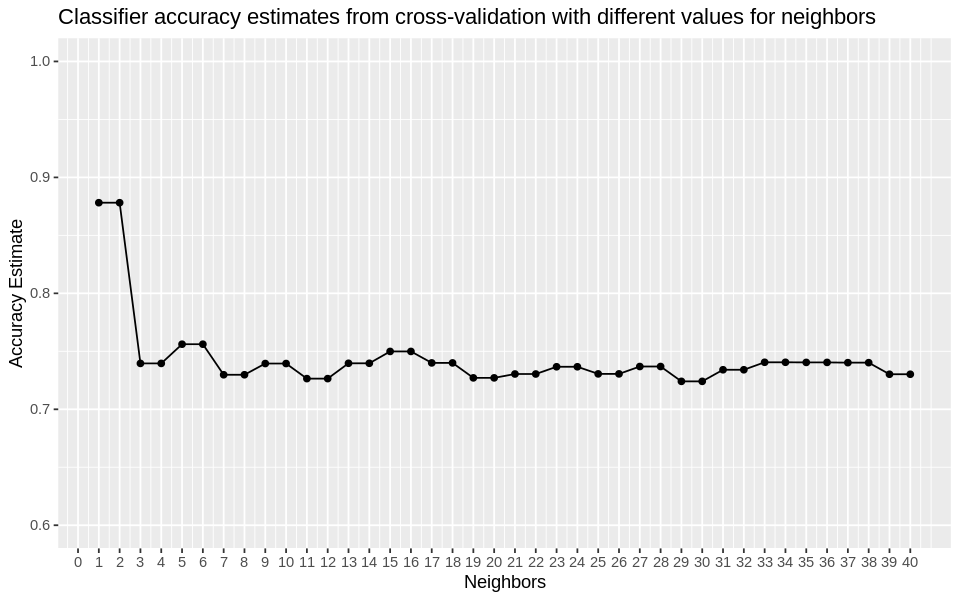

In [18]:
# Find the best k value
set.seed(2130)

gridvals <- tibble(neighbors = seq(from = 1, to = 40, by = 1))

#1. Make the recipe (what are the predictors, which is the response variable, what is the data set)
knn_recipe_k_tuning <- recipe(DEATH_EVENT ~ creatinine_phosphokinase+ejection_fraction+age+diabetes+serum_creatinine, data = balanced_data)

#2. Perform 5-fold CV on the training set
knn_vfold_k_tuning <- vfold_cv(balanced_data, v = 5, strata = DEATH_EVENT)

#3. Create the specs with tune() for number of neighbors
knn_k_tuning <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_k_tuning_results <- workflow() |>
    add_recipe(knn_recipe_k_tuning) |>
    add_model(knn_k_tuning) |>
    tune_grid(resamples = knn_vfold_k_tuning, grid = gridvals) |>
    collect_metrics()
                 
accuracies_k_tuning <- knn_k_tuning_results |> 
       filter(.metric == "accuracy")

cross_val_plot <- ggplot(accuracies_k_tuning, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       ggtitle("Classifier accuracy estimates from cross-validation with different values for neighbors") +
       scale_x_continuous(breaks = seq(0, 40, by = 1)) +  # adjusting the x-axis
       scale_y_continuous(limits = c(0.6, 1.0)) # adjusting the y-axis

cross_val_plot        



In [46]:
# Find the best model and test it against the testing set
set.seed(2130)

best_k <- 15

#1. Make the recipe (what are the predictors, which is the response variable, what is the data set)
knn_recipe_best <- recipe(DEATH_EVENT ~  creatinine_phosphokinase+ejection_fraction+age+diabetes+serum_creatinine, data = balanced_data)

knn_spec_best <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_best_fit <- workflow() |>
    add_recipe(knn_recipe_best) |>
    add_model(knn_spec_best) |>
    fit(data = balanced_data)

                 
hf_predictions <- predict(knn_best_fit, testing_data) |>
    bind_cols(testing_data)

hf_metrics <- hf_predictions |>
    metrics(truth = DEATH_EVENT, estimate = .pred_class) |>
    filter(.metric == "accuracy")

hf_conf_mat <- hf_predictions |>
    conf_mat(truth = DEATH_EVENT, estimate = .pred_class)

In [20]:
# Find the best model based on the paper and test it against the testing set
set.seed(2130)

best_k_paper <- 15

#1. Make the recipe (what are the predictors, which is the response variable, what is the data set)
knn_recipe_paper_best <- recipe(DEATH_EVENT ~ ejection_fraction + serum_creatinine, data = balanced_data)

knn_spec_paper_best <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k_paper) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_best_fit_paper <- workflow() |>
    add_recipe(knn_recipe_paper_best) |>
    add_model(knn_spec_paper_best) |>
    fit(data = balanced_data)

                 
hf_predictions_paper <- predict(knn_best_fit_paper, testing_data) |>
    bind_cols(testing_data)

hf_metrics_paper <- hf_predictions_paper |>
    metrics(truth = DEATH_EVENT, estimate = .pred_class) |>
    filter(.metric == "accuracy")

hf_conf_mat_paper <- hf_predictions_paper |>
    conf_mat(truth = DEATH_EVENT, estimate = .pred_class)

In [21]:
# Compare our model and the paper model
models <- c("Ours", "Paper's")
model_formula <- c("DEATH_EVENT ~ creatinine_phosphokinase+ejection_fraction+age+diabetes+serum_creatinine", 
                   "DEATH_EVENT ~ ejection_fraction + serum_creatinine")
pred_accu_ours <- hf_metrics |>
    select(.estimate) |>
    pull()

pred_accu_paper <- hf_metrics_paper |>
    select(.estimate) |>
    pull()

prediction_accuracy <- c(pred_accu_ours, pred_accu_paper)

prediction_summary <- tibble(models, model_formula, prediction_accuracy)
colnames(prediction_summary) <- c("Model", "Model Formula", "Prediction accuracy on testing data")
prediction_summary

Model,Model Formula,Prediction accuracy on testing data
<chr>,<chr>,<dbl>
Ours,DEATH_EVENT ~ creatinine_phosphokinase+ejection_fraction+age+diabetes+serum_creatinine,0.8133333
Paper's,DEATH_EVENT ~ ejection_fraction + serum_creatinine,0.7733333


In [22]:
# Our model's confusion matrix
hf_conf_mat

          Truth
Prediction  0  1
         0 43  6
         1  8 18

In [23]:
# Paper model's confusion matrix
hf_conf_mat_paper

          Truth
Prediction  0  1
         0 41  7
         1 10 17

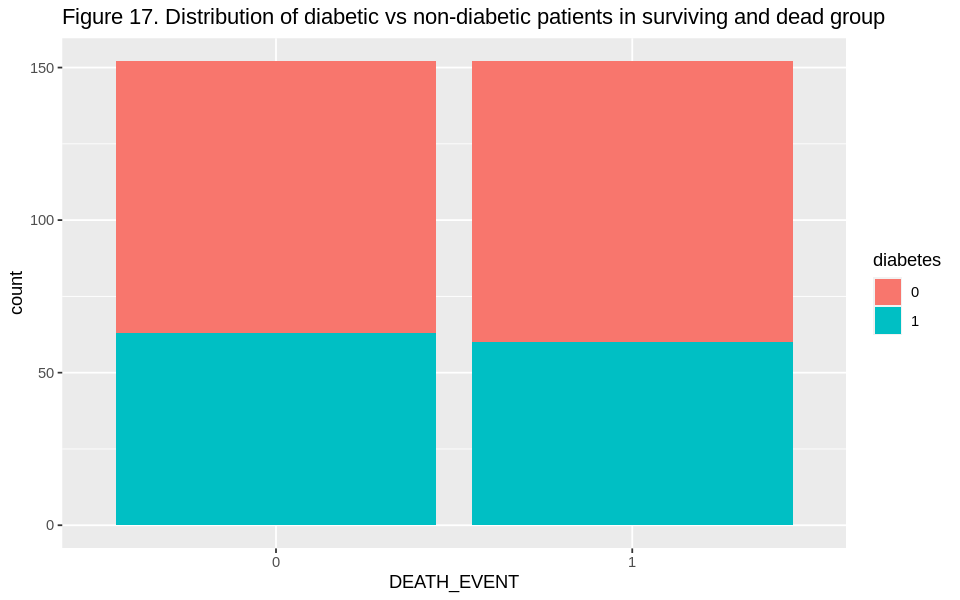

In [ ]:
# diabetes_dead, diabetes_survived, nondiabetes_dead, nondiabetes_survived
diabetes <- balanced_data |>
ggplot(aes(x = DEATH_EVENT, fill = diabetes)) +
    geom_bar() +
ggtitle("Figure 17. Distribution of diabetic vs non-diabetic patients in surviving and dead group")
diabetes

## Discussion

#### Discuss whether this is what you expected to find?

Among all the model formulas forward selection gives us, creatinine phosphokinase + ejection fraction + diabetes + age + serum creatinine has the highest accuracy at 87.8%. Before we run forward selection, we expected the outcome to be serum creatinine, ejection fraction (Table 1, Fig. 1~8, Chicco & Jurman, 2020), and some categorical variables. Our result is almost the same as our expected outcome, except for creatinine phosphokinase and age.

We could find the reason ejection fraction, age, and serum creatinine are chosen as useful predictors from the histograms of our training set. In Figure 10, half of the survived patients have an ejection fraction above 40%; however, the ejection fraction for most of those who died is below 40%. There is a higher possibility for heart failure patients to die if their ejection fraction is low. For age, Figure 11 shows that the distribution of the dead group is left-skewed while that of the survived group is right-skewed. It implies that older people are more likely to die from heart failure. Moreover, the serum creatinine level of survived patients centers around 1.5 mg/dL, while that of dead patients is more spread out with a higher mean value. Higher serum creatinine leads to higher mortality rate.

However, from the exploratory data analysis of our training set, it is difficult to tell why creatinine phosphokinase and diabetes contribute to higher accuracy of the classification model. From the distribution of creatinine phosphokinase for our training data, there is almost no difference between the dead and surviving groups. A research paper suggests that low level of creatinine phosphokinase leads to heart failure, but “severity is dependent on genetic background, gender and age”, which means creatinine phosphokinase level is not directly related to mortality of heart failure (Lygate, 2012). Also, in our training set, there is roughly the same number of patients with and without diabetes in each group. According to research on the impact of diabetes mellitus on mortality in patients with acute heart failure, “diabetes mellitus is associated with a higher risk of overall mortality in acute heart failure” (Kong, 2020). Our training data contradicts the result of this research paper, but diabetes is still picked as a useful predictor.


Lygate, C.A., Medway, D.J., Ostrowski, P.J. et al. Chronic creatine kinase deficiency eventually leads to congestive heart failure, but severity is dependent on genetic background, gender and age. Basic Res Cardiol 107, 276 (2012). https://doi.org/10.1007/s00395-012-0276-2

Kong, M.G., Jang, S.Y., Jang, J. et al. Impact of diabetes mellitus on mortality in patients with acute heart failure: a prospective cohort study. Cardiovasc Diabetol 19, 49 (2020). https://doi.org/10.1186/s12933-020-01026-3



## Methods

A k-nearest-neighbor classifier will be made to answer the proposed question. Most importantly, the variable time (follow-up period) will be excluded because it is different for each patient, and there were no details regarding the kind of follow-ups, which makes it harder to understand the role of this predictor. We acknowledge that this is a simplification, and that our model only predicts whether a patient will die or not after some finite time, but the amount of time does not matter. For variable selection, best subset selection will be attempted first, but if it ends up being non-feasible due to high volumes of computations, we would use forward selection which is less computationally costly. The selected classifier will then be trained with the best K-value found from cross-validation. 

During the process of building our model, visualising the result of each step would be crucial for analysing the result. We can achieve that by generating different charts using the ggplot function. For example, when choosing a k-value with the highest accuracy, we would apply cross-validation, and visualize the result (k-value verses accuracy) by geom_line() function.


## Expected Outcomes and Significance


#### Expected Outcomes:

From our summaries and past studies' findings, we expect our model to use not only serum creatinine and ejection fraction as predictors (Table 1, Fig. 1~8, Chicco & Jurman, 2020), but also the categorical variables that describe a patient’s gender, and statuses regarding anaemia, high blood pressure, and smoking because either the differences between their summary statistics (survived vs dead patients) for those variables are relatively greater or that past studies have found correlation between them and patient death (Table 2, Chairat et al., 2022, Ding et al., 2022, Romiti et al., 2022).


#### Significance:

The model could identify potential factors that correlate with heart failure mortality. From that, we could advocate for better living habits if lifestyle-related factors such as smoking is a major predictor for death of heart failure patients. In the case of biological factors such as serum creatinine levels being correlated with heart failure mortality, researchers could look into potential drug treatments that regulate their levels in patients’ bodies to prolong their lifespans. 

#### Future Directions:

The model for this project is merely predicting whether a heart failure patient will die or not based on some health information and the time factor is ignored for simplification. For future projects, a more impactful model we could work on is one that can predict the patient’s probability of survival after some specific amount of time given their current health information.
 

## References:

1. Ahmad, T., Munir, A., Bhatti, S. H., Aftab, M., & Raza, M. A. (2017). Survival analysis of heart failure patients: A case study. *PloS One, 12*(7), e0181001-e0181001. https://doi.org/10.1371/journal.pone.0181001

2. Chairat, K., Rattanavipanon, W., Tanyasaensook, K., Chindavijak, B., Chulavatnatol, S., & Nathisuwan, S. (2020). Relationship of anemia and clinical outcome in heart failure patients with preserved versus reduced ejection fraction in a rural area of Thailand. *International Journal of Cardiology. Heart & Vasculature*, 30, 100597-100597. https://doi.org/10.1016/j.ijcha.2020.100597.

3. Chicco, D., & Jurman, G. (2020). Machine learning can predict survival of patients with heart failure from serum creatinine and ejection fraction alone. *BMC Medical Informatics and Decision Making, 20*(1), 16-16. https://doi.org/10.1186/s12911-020-1023-5

4. Ding, N., Shah, A. M., Blaha, M. J., Chang, P. P., Rosamond, W. D., & Matsushita, K. (2022). Cigarette smoking, cessation, and risk of heart failure with preserved and reduced ejection fraction. *Journal of the American College of Cardiology, 79*(23), 2298-2305. https://doi.org/10.1016/j.jacc.2022.03.377

5. Inamdar, A. A., & Inamdar, A. C. (2016). Heart Failure: Diagnosis, Management and Utilization. *Journal of Clinical Medicine, 5*(7), 62. https://doi.org/10.3390/jcm5070062

6. Romiti, G. F., Recchia, F., Zito, A., Visioli, G., Basili, S., & Raparelli, V. (2022, April 21). Sex and gender-related issues in heart failure. *Cardiology Clinics, 40*(2), 259-268. https://doi.org/10.1016/j.ccl.2021.12.013